# Wheat Seed Dataset

# 1: Introduction

The Wheat Seeds Dataset involves the prediction of species given measurements of seeds from different varieties of wheat.

It is a classification problem. The number of observations for each class is balanced. There are 199 observations with 7 input variables and 1 output variable. The variable names are as follows:

<br> 1. Area.
<br> 2. Perimeter.
<br> 3. Compactness
<br> 4. Length of kernel.
<br> 5. Width of kernel.
<br> 6. Asymmetry coefficient.
<br> 7. Length of kernel groove.
<br> 8. Class (1, 2, 3).


# 2: Data Pre processing

## 2.1 Loading the required Libraries

In [123]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Pytorch Lib
import torch
import random
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F

## 2.2 Get Data

In [124]:
import numpy as np
import os
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
## Loading the dataset from github repo
url = 'https://raw.githubusercontent.com/hargurjeet/MachineLearning/Wheat-Seeds/seeds.csv'
df = pd.read_csv(url)

df.head()

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [126]:
df.shape

(199, 8)

In [127]:
df.Type.value_counts()

2    68
1    66
3    65
Name: Type, dtype: int64

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             199 non-null    float64
 1   Perimeter        199 non-null    float64
 2   Compactness      199 non-null    float64
 3   Kernel.Length    199 non-null    float64
 4   Kernel.Width     199 non-null    float64
 5   Asymmetry.Coeff  199 non-null    float64
 6   Kernel.Groove    199 non-null    float64
 7   Type             199 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


## 2.3 Feature Analysis

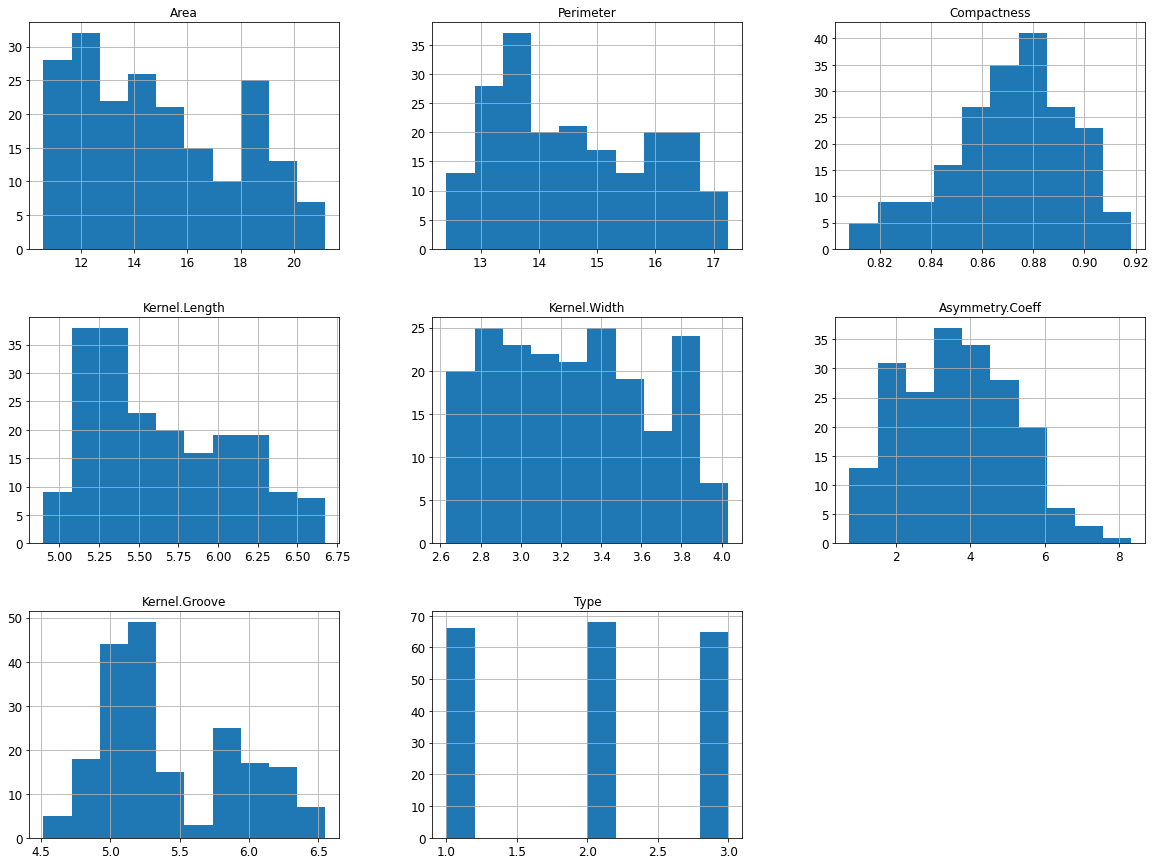

In [129]:
df.hist(figsize=(20,15));

From the above graph it is very difficult to conclude anything. Hence I see the co relation below

In [130]:
df.corr()

,Area,Perimeter,Compactness,Kernel.Length,Kernel.Width,Asymmetry.Coeff,Kernel.Groove,Type
Area,1.000000,0.994437,0.609887,0.951126,0.970980,-0.222820,0.862727,-0.340664
Perimeter,0.994437,1.000000,0.531841,0.972944,0.945496,-0.211034,0.889543,-0.322223
Compactness,0.609887,0.531841,1.000000,0.374011,0.762167,-0.329400,0.227016,-0.539261
Kernel.Length,0.951126,0.972944,0.374011,1.000000,0.862680,-0.169704,0.932124,-0.249422
Kernel.Width,0.970980,0.945496,0.762167,0.862680,1.000000,-0.253122,0.748228,-0.421961
Asymmetry.Coeff,-0.222820,-0.211034,-0.329400,-0.169704,-0.253122,1.000000,-0.003349,0.573956
Kernel.Groove,0.862727,0.889543,0.227016,0.932124,0.748228,-0.003349,1.000000,0.035508
Type,-0.340664,-0.322223,-0.539261,-0.249422,-0.421961,0.573956,0.035508,1.000000


Following are my observation

- Kernel Length and width seems to have strong relation with Area
- Kernel Length and width seems to have strong relation with Perimeter
- Area and Perimeter have a strong relation with Groove
- Groove is very close to Zero(0.03) againt Type, Hence confirming there is no linear relation.


I now plot all the above mentioned point for each Type. Plotting Area and Kernal Lenght for each Type.

### 2.3.1 Area Vs Kernal length

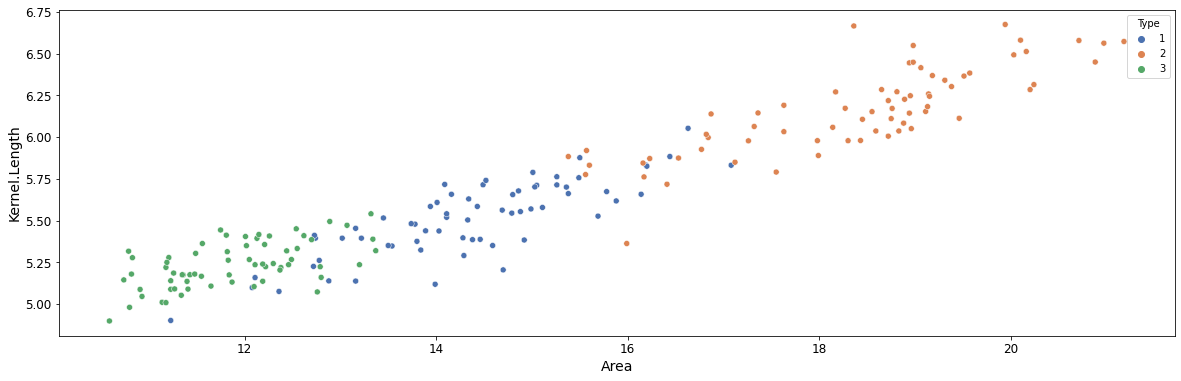

In [131]:
plt.rcParams["figure.figsize"] = (20,6)
sns.scatterplot(data=df, x="Area", y="Kernel.Length", hue="Type",  palette="deep");

### 2.3.2 Area Vs Kernal Width
Plotting Area and Kernal Width for each Type.

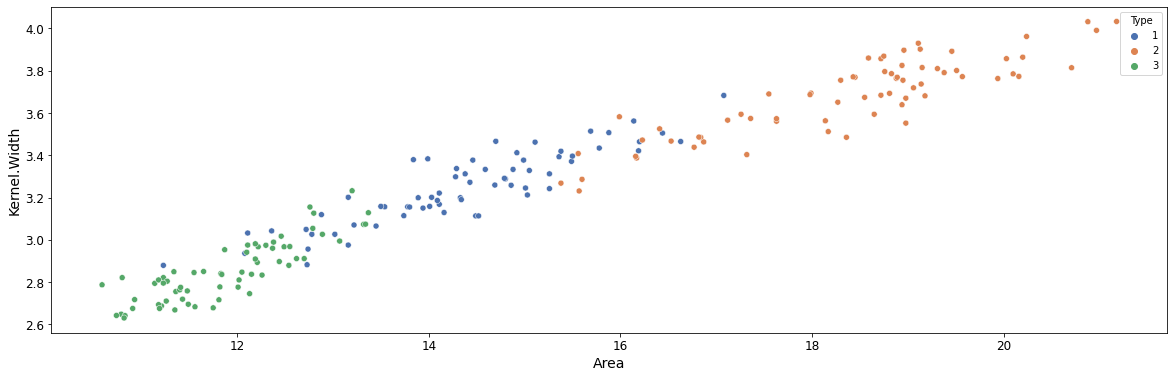

In [132]:
sns.scatterplot(data=df, x="Area", y="Kernel.Width", hue="Type", palette="deep");

I observe the data overlap between Type 1 and Type 2 and minimal overlap with type 3. Hence i conclude while Typel 1 and Type 2 seeds might be similar in Width but Type 3 seeds are definately greater in size.

### 2.3.3 Plotting Groove Vs Perimeter

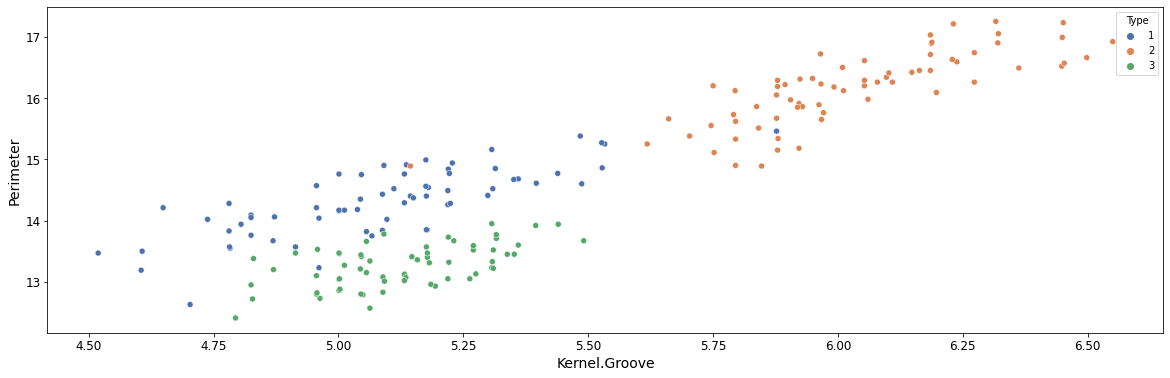

In [133]:
sns.scatterplot(data=df, x="Kernel.Groove", y="Perimeter", hue="Type", palette="deep");

### 2.3.4 Area Vs Kernal Groove

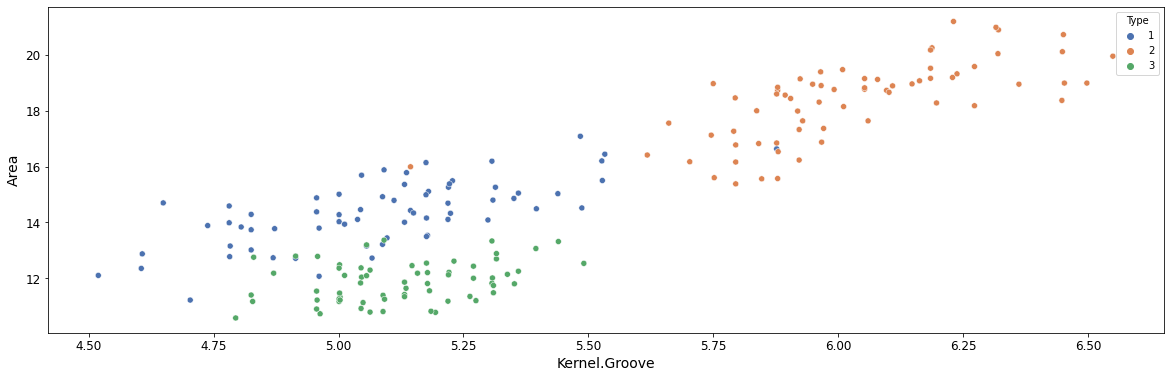

In [134]:
sns.scatterplot(data=df, x="Kernel.Groove", y="Area", hue="Type", palette="deep");

I observe cluster's for Type 1,2 and 3 for the data points. This situation is ideal for neural network as relations of features against the labels is not clear.

# 3: Preparing the data for ML model using PyTorch

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. This following function will perform the conversion to numpy arrays.

In [135]:
# Converting the data to tensors
from torch.utils.data import random_split
import torch
import random
from torch.utils.data import TensorDataset

# this is to update the labels from 1, 2, 3 to 0, 1, 2
def update_values_(df):
  for i in range(len(df)):
    df[i] = df[i] - 1

  return df

train_target = torch.tensor(df['Type'].values.astype(np.int64))
train = torch.tensor(df.drop('Type', axis = 1).values.astype(np.float32))


train_tensor = TensorDataset(train, update_values_(train_target))

train_ds, val_ds = random_split(train_tensor, [180, 19])
len(train_ds), len(val_ds)

(180, 19)

In [136]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

In [137]:
import torch.nn as nn

input_size = 1*7
num_classes = 3

model = nn.Linear(input_size, num_classes)

In [138]:
class Wheatseed(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        # xb = xb.reshape(-1, 7)
        out = self.linear(xb)
        return out
    
model = Wheatseed()

In [139]:
model.linear

Linear(in_features=7, out_features=3, bias=True)

In [140]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    print(labels.shape)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([64, 7])
torch.Size([64])
outputs.shape :  torch.Size([64, 3])
Sample outputs :
 tensor([[5.7391, 0.3601, 2.7418],
        [7.3783, 0.0444, 3.0794]])


In [141]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history


def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [142]:
class Wheatseed(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        # xb = xb.reshape(-1, 7)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = Wheatseed()

In [143]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Before we train the model, let's see how the model performs on the validation set with the initial set of randomly initialized weights & biases.


In [144]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.31578946113586426, 'val_loss': 1.8727011680603027}

The initial accuracy is around 52%, which one might expect from a randomly initialized model.

We are now ready to train the model. Let's train for five epochs and look at the results.

In [91]:
model = Wheatseed()

In [145]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4956, val_acc: 0.4737
Epoch [1], val_loss: 1.2353, val_acc: 0.5789
Epoch [2], val_loss: 1.0488, val_acc: 0.5789
Epoch [3], val_loss: 0.9282, val_acc: 0.6316
Epoch [4], val_loss: 0.8510, val_acc: 0.7368


In [146]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8104, val_acc: 0.7368
Epoch [1], val_loss: 0.7880, val_acc: 0.7368
Epoch [2], val_loss: 0.7761, val_acc: 0.7368
Epoch [3], val_loss: 0.7705, val_acc: 0.7895
Epoch [4], val_loss: 0.7658, val_acc: 0.7895


In [147]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7627, val_acc: 0.7368
Epoch [1], val_loss: 0.7595, val_acc: 0.7368
Epoch [2], val_loss: 0.7578, val_acc: 0.7368
Epoch [3], val_loss: 0.7566, val_acc: 0.7895
Epoch [4], val_loss: 0.7566, val_acc: 0.7895


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

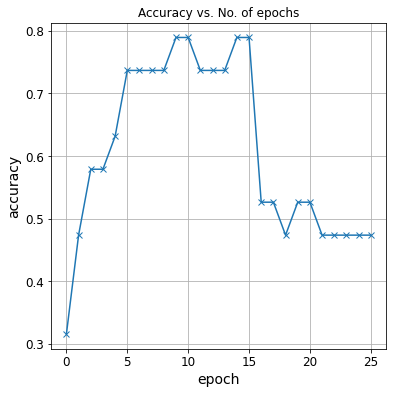

In [154]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.title('Accuracy vs. No. of epochs')
plt.show();

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 80% even after training for a very long time. One possible reason for this is that the learning rate might be too high. The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss. You can try reducing the learning rate and training for a few more epochs to see if it helps.

The more likely reason that the model just isn't powerful enough. There are variour technique to improve the performace of the model but that might be beyond the scope of this notebook. 